In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as datasets
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import copy

## Lets imidiatly start with importing the data of MotionSense

In [5]:
path_to_load = r'\DL_Course\data_np'
batch_size = 128

In [6]:
train_data_tot_np = np.load(r'{}\train_data.npy'.format(path_to_load))
train_labels_tot_np = np.load(r'{}\train_labels.npy'.format(path_to_load))

val_data_tot_np = np.load(r'{}\val_data.npy'.format(path_to_load))
val_labels_tot_np = np.load(r'{}\val_labels.npy'.format(path_to_load))

test_data_total_np = np.load(r'{}\test_data.npy'.format(path_to_load))
test_labels_total_np = np.load(r'{}\test_labels.npy'.format(path_to_load))

FileNotFoundError: [Errno 2] No such file or directory: '\\DL_Course\\data_np\\train_data.npy'

In [ ]:
train_dataset = TensorDataset(torch.tensor(train_data_tot_np,dtype = torch.float32), torch.tensor(train_labels_tot_np,dtype =  torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )

val_dataset = TensorDataset(torch.tensor(val_data_tot_np,dtype = torch.float32), torch.tensor(val_labels_tot_np,dtype =  torch.long))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True )

test_dataset = TensorDataset(torch.tensor(test_data_total_np,dtype = torch.float32), torch.tensor(test_labels_total_np,dtype =  torch.long))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True )

In [ ]:
print('Train loader dataset size: {} and labels: {}'.format(train_loader.dataset[:][0].shape ,train_loader.dataset[:][1].shape ))
print('Val loader dataset size: {} and labels: {}'.format(val_loader.dataset[:][0].shape ,val_loader.dataset[:][1].shape ))
print('Teest loader dataset size: {} and labels: {}'.format(test_loader.dataset[:][0].shape ,test_loader.dataset[:][1].shape ))

Train loader dataset size: torch.Size([36462, 6, 50]) and labels: torch.Size([36462])
Val loader dataset size: torch.Size([8275, 6, 50]) and labels: torch.Size([8275])
Teest loader dataset size: torch.Size([5281, 6, 50]) and labels: torch.Size([5281])


In [ ]:
MS_HAR_labels = test_loader.dataset[:][1].unique()
MS_HAR_labels

tensor([0, 1, 2, 3, 4, 5])

## Lets create a CNN with three 1DCNN and two FC layer

**This time we will use sequential and maxpool**

In [ ]:
def train_model(f_model , device_to_use , train_loader , val_loader , f_loss, f_optim,f_scheduler  , num_epochs, use_argmax = True):
    best_model_epoch = 0
    best_model_acc_val = 0
    best_model_loss_val = 10000
    best_model_weights = copy.deepcopy(f_model.state_dict())
    f_model = f_model.to(device_to_use)
    print('Training loop running on device: {}'.format(device_to_use))
    tot_train_loss = []
    tot_val_loss = []
    tot_train_acc = []
    tot_val_acc = []
    for epoch_i in range(num_epochs):
        # We set the model to training mode and start the training on the train_loader
        running_train_loss = []
        running_train_acc = []
        train_preds = []
        f_model.train() # this makes the backprop possible, meaning we will be able to update the weights and biases
        for data , labels in train_loader:
            f_optim.zero_grad() # we zero the gradients
            data = data.to(device_to_use)
            labels = labels.to(device_to_use)
            preds = f_model(data)
            if use_argmax:
                loss_val = f_loss(preds , labels)
                running_train_acc.append((preds.detach().cpu().argmax(dim = 1).numpy() == labels.cpu().numpy()).sum() / labels.cpu().shape[0] * 100)
            else:
                loss_val = f_loss(preds.log_softmax(dim = 1) , labels)
                running_train_acc.append((preds.detach().cpu().log_softmax(dim = 1).argmax(dim = 1).numpy() == labels.cpu().numpy()).sum() / labels.shape[0] * 100)
            running_train_loss.append(loss_val.item())
            # we need to save the best performing class as predictions

            # loss_val.backward(loss_val) # we propogate the loss backwards and update the weights and biases
            loss_val.backward() # we propogate the loss backwards and update the weights and biases
            f_optim.step()

        tot_train_loss.append(np.mean(running_train_loss))
        tot_train_acc.append(np.mean(running_train_acc))
        # print(tot_train_acc)


        f_model.eval() # here we set the model as eval meaning we are evaluating the model
        #   !!!! we would not be able to update the weight and to backprop!!!!!
        running_val_loss = []
        running_val_acc = []
        val_preds = []
        with torch.no_grad(): # runing without gradients to makesure no update is happening
            for data_val , labels_val in val_loader:
                data_val = data_val.to(device_to_use)
                labels_val = labels_val.to(device_to_use)
                preds_val = f_model(data_val)
                if use_argmax:
                    loss_val = f_loss(preds_val, labels_val)
                    running_val_acc.append((preds_val.detach().cpu().argmax(dim = 1).numpy() == labels_val.cpu().numpy()).sum() / labels_val.cpu().shape[0] * 100)
                else:
                    loss_val = f_loss(preds_val.log_softmax(dim = 1), labels_val)
                    running_val_acc.append((preds_val.detach().cpu().log_softmax(dim = 1).argmax(dim = 1).numpy() == labels_val.cpu().numpy()).sum() / labels_val.cpu().shape[0] * 100)
                running_val_loss.append(loss_val.item())
        f_scheduler.step()
        tot_val_loss.append(np.mean(running_val_loss))
        tot_val_acc.append(np.mean(running_val_acc))
        # print(tot_val_acc)
        if epoch_i % 10:
            print('Epoch [{}/{}] train loss: {:.4f} train accuracy: {:.1f} [%] || validation loss: {:.4f} and validation accuracy: {:.1f} [%]'.format(epoch_i+1 ,
                        num_epochs,tot_train_loss[-1] , tot_train_acc[-1],tot_val_loss[-1] , tot_val_acc[-1]))
        
        if tot_val_acc[-1] >= best_model_acc_val:
            best_model_loss_val = tot_val_loss[-1]
            best_model_epoch = epoch_i
            best_model_acc_val = tot_val_acc[-1]
            best_model_weights = copy.deepcopy(f_model.state_dict()) # save best performing model weights
    # outside epoch loop.
    print('**** Done training - best model at epoch {} with val loss: {} and accuracy: {}'.format(best_model_epoch ,best_model_loss_val,best_model_acc_val ))
    f_model.load_state_dict(best_model_weights)
    return f_model , tot_train_loss, tot_val_loss , tot_train_acc , tot_val_acc

In [ ]:
def test_model(model , device_to_use , test_loader , use_argmax = True):
    model.eval() # here we set the model as eval meaning we are testing the model
    #   !!!! we would not be able to update the weight and to backprop!!!!!
    running_test_acc = []
    test_predictions = []
    labels_list = []
    for test_d , test_l in test_loader:
        test_d = test_d.to(device_to_use)
        test_l = test_l.to(device_to_use)
        test_p = model(test_d)
        if use_argmax == True:
            test_predictions.extend(test_p.argmax(dim = 1).detach().cpu().numpy())
        else:
            test_predictions.extend(test_p.detach().cpu().log_softmax(dim = 1).argmax(dim = 1).numpy())
        labels_list.extend(test_l.detach().cpu().numpy())
    running_test_acc = (np.array(test_predictions) == np.array(labels_list)).sum()/np.array(labels_list).shape[0] * 100
    return test_predictions,labels_list , running_test_acc

## Lets compare two networks, simple DNN like before and the CNN

In [ ]:
class First_1DCNN(torch.nn.Module):
    def __init__(self, in_channels = 6,leaky_rate = 0.05 , output_size = 1):
        super(First_1DCNN, self).__init__()
        self.in_channels = in_channels
        self.out_size = output_size
        self.leaky_rate = leaky_rate
        
        self.conv_1 = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels = self.in_channels , out_channels = 16,kernel_size = 10,stride = 1,padding = 0 ),
            torch.nn.LeakyReLU(self.leaky_rate),
            torch.nn.MaxPool1d(2),
        )
        self.conv_2 = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels = 16 , out_channels = 64,kernel_size = 10,stride = 1, padding = 0),
            torch.nn.LeakyReLU(self.leaky_rate),
            torch.nn.MaxPool1d(2),
        )
        # self.conv_3 = torch.nn.Sequential(
        #     torch.nn.Conv1d(in_channels = 16 , out_channels = 16,kernel_size = 5,stride = 1, padding = 0),
        #     torch.nn.LeakyReLU(self.leaky_rate),
        #     torch.nn.MaxPool1d(2),
        # )
        self.fc_1 = torch.nn.Sequential(
            torch.nn.Linear(320 , 64),
            torch.nn.Tanh(),
            torch.nn.Dropout(0.3),
        )
        self.fc_2 = torch.nn.Sequential(
            torch.nn.Linear(64 , self.out_size),
            torch.nn.Softmax(dim = 1),
        )
        
    def forward(self, x):
        # Note we dont flatten the input
        conv_out = self.conv_1(x)
        conv_out = self.conv_2(conv_out)
        # conv_out = self.conv_3(conv_out)

        fc_in = torch.flatten(conv_out,start_dim =1)
        fc_out = self.fc_1(fc_in)
        net_out = self.fc_2(fc_out)
        return net_out

In [ ]:
class Multiclass_DNN_Tut7(torch.nn.Module):
    def __init__(self, input_size = 784 , output_size = 1):
        super(Multiclass_DNN_Tut7, self).__init__()
        self.fc_1 = torch.nn.Linear(input_size , 128)
        self.fc_2 = torch.nn.Linear(128 , 128)
        # self.fc_2_1 = torch.nn.Linear(128 , 128)
        self.fc_3 = torch.nn.Linear(128 , output_size)
        self.softmax_f = torch.nn.Softmax(dim = 1)
        self.tanh_act = torch.nn.Tanh()
        self.dropout = torch.nn.Dropout(0.3)
        
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        hidden_out = self.dropout(self.tanh_act(self.fc_1(x)))
        hidden_out = self.dropout(self.tanh_act(self.fc_2(hidden_out)))
        # hidden_out = self.dropout(self.relu_act(self.fc_2_1(hidden_out)))
        net_out = self.softmax_f(self.fc_3(hidden_out))
        # net_out = (self.fc_3(hidden_out))
        return net_out

**Dont forget to set the seed**

In [ ]:
torch.manual_seed(22)
#torch.cuda.manual_seed(22) # if you have a GPU

## Lets start Training

**First lets set the benchmark**

In [ ]:
Baseline_DNN = Multiclass_DNN_Tut7(6*50,len(MS_HAR_labels))
total_params = np.array([p.numel() for p in Baseline_DNN.parameters()]).sum()
print(f"Number of parameters: {total_params}")
CEloss = torch.nn.CrossEntropyLoss()
NllLoss = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(Baseline_DNN.parameters() , lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
epochs = 30

Number of parameters: 55814


In [ ]:
device_to_use = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device_to_use.type == 'cpu':
    print('Running on: ', device_to_use)
else:
    print('Running on: ', device_to_use, ' Device name: ', torch.cuda.get_device_name(device=device_to_use))

Running on:  cpu


In [ ]:
Baseline_DNN , FC_tot_train_loss, FC_tot_val_loss , FC_tot_train_acc , FC_tot_val_acc = train_model(Baseline_DNN , device_to_use , 
                                    train_loader , val_loader , CEloss, optimizer,scheduler  , epochs , use_argmax=True)

Training loop running on device: cpu
Epoch [2/30] train loss: 1.3043 train accuracy: 73.6 [%] || validation loss: 1.2192 and validation accuracy: 82.4 [%]
Epoch [3/30] train loss: 1.2809 train accuracy: 75.9 [%] || validation loss: 1.2052 and validation accuracy: 83.7 [%]
Epoch [4/30] train loss: 1.2648 train accuracy: 77.6 [%] || validation loss: 1.1972 and validation accuracy: 84.6 [%]
Epoch [5/30] train loss: 1.2553 train accuracy: 78.4 [%] || validation loss: 1.1939 and validation accuracy: 85.0 [%]
Epoch [6/30] train loss: 1.2493 train accuracy: 79.0 [%] || validation loss: 1.1789 and validation accuracy: 86.4 [%]
Epoch [7/30] train loss: 1.2440 train accuracy: 79.5 [%] || validation loss: 1.1681 and validation accuracy: 87.5 [%]
Epoch [8/30] train loss: 1.2377 train accuracy: 80.2 [%] || validation loss: 1.1733 and validation accuracy: 86.8 [%]
Epoch [9/30] train loss: 1.2357 train accuracy: 80.4 [%] || validation loss: 1.1708 and validation accuracy: 87.1 [%]
Epoch [10/30] train

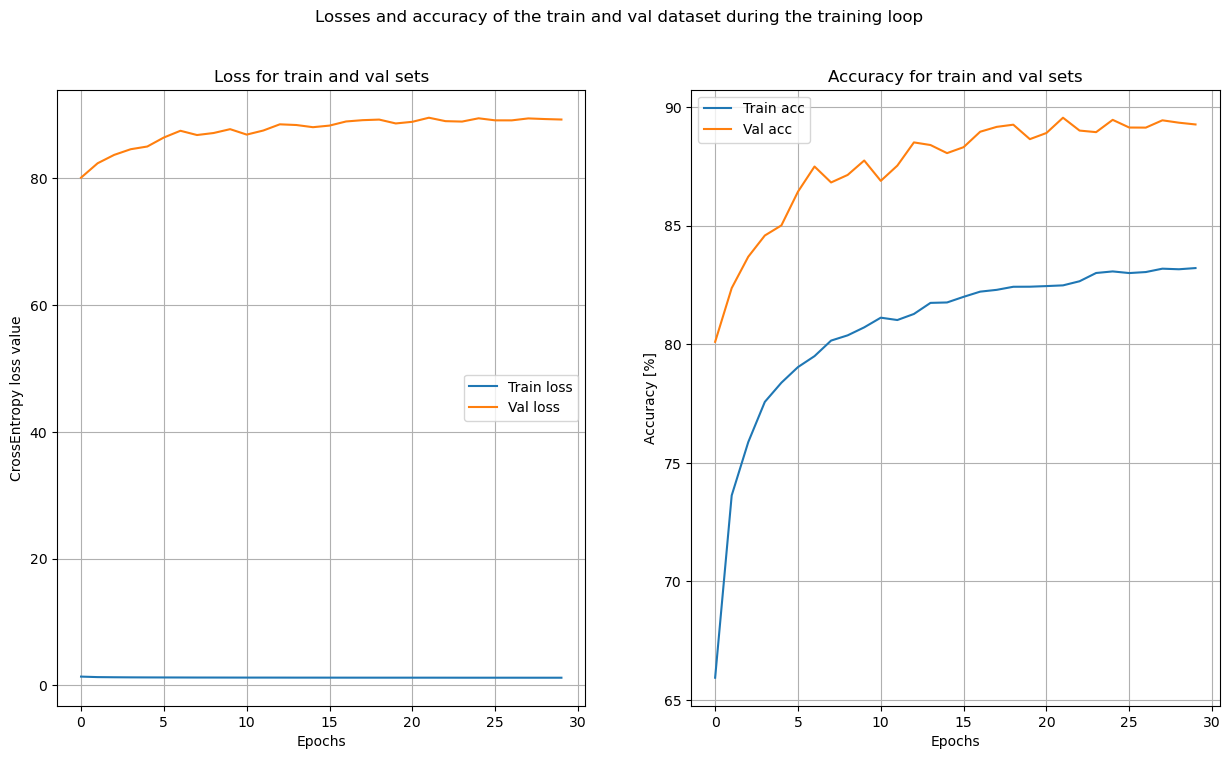

In [ ]:
fig, axs = plt.subplots(ncols = 2 , nrows = 1, figsize = (15,8))
fig.suptitle('Losses and accuracy of the train and val dataset during the training loop')
axs[0].set_title('Loss for train and val sets')
axs[0].plot(FC_tot_train_loss,label = 'Train loss')
axs[0].plot(FC_tot_val_acc, label = 'Val loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('CrossEntropy loss value')
axs[0].grid()
axs[0].legend()

axs[1].set_title('Accuracy for train and val sets')
axs[1].plot(FC_tot_train_acc,label = 'Train acc')
axs[1].plot(FC_tot_val_acc, label = 'Val acc')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy [%]')
axs[1].grid()
axs[1].legend()
plt.show()

In [ ]:
FC_predictions ,FC_labels_list, FC_tot_test_acc = test_model(Baseline_DNN , device_to_use , test_loader,use_argmax= True )
print('Test accuracy {}'.format(FC_tot_test_acc))

Test accuracy 87.02897178564666


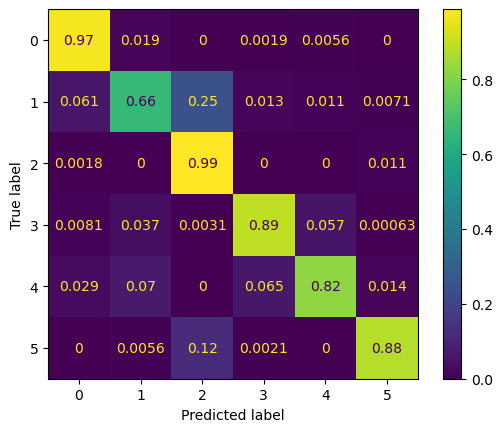

In [ ]:
test_QM = confusion_matrix(FC_predictions,FC_labels_list,normalize = 'true')
cm_display = ConfusionMatrixDisplay(confusion_matrix = test_QM, display_labels = MS_HAR_labels.numpy())
cm_display.plot()

**Lets continue with the CNN**

In [ ]:
Our_First_CNN = First_1DCNN(in_channels=6,leaky_rate=0.05,output_size=len(MS_HAR_labels))
total_params = np.array([p.numel() for p in Our_First_CNN.parameters()]).sum()
print(f"Number of parameters: {total_params}")
CEloss = torch.nn.CrossEntropyLoss()
NllLoss = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(Our_First_CNN.parameters() , lr = 0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
epochs = 30

Number of parameters: 32214


In [ ]:
device_to_use = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device_to_use.type == 'cpu':
    print('Running on: ', device_to_use)
else:
    print('Running on: ', device_to_use, ' Device name: ', torch.cuda.get_device_name(device=device_to_use))

Running on:  cpu


In [ ]:
Our_First_CNN , CNN_tot_train_loss, CNN_tot_val_loss , CNN_tot_train_acc , CNN_tot_val_acc = train_model(Our_First_CNN , device_to_use , 
                                    train_loader , val_loader , CEloss, optimizer,scheduler  , epochs , use_argmax=True)

Training loop running on device: cpu
Epoch [2/30] train loss: 1.2094 train accuracy: 84.3 [%] || validation loss: 1.2158 and validation accuracy: 83.2 [%]
Epoch [3/30] train loss: 1.1698 train accuracy: 87.8 [%] || validation loss: 1.2068 and validation accuracy: 83.8 [%]
Epoch [4/30] train loss: 1.1570 train accuracy: 88.9 [%] || validation loss: 1.1933 and validation accuracy: 85.1 [%]
Epoch [5/30] train loss: 1.1410 train accuracy: 90.6 [%] || validation loss: 1.1625 and validation accuracy: 88.8 [%]
Epoch [6/30] train loss: 1.0964 train accuracy: 95.3 [%] || validation loss: 1.1301 and validation accuracy: 91.6 [%]
Epoch [7/30] train loss: 1.0819 train accuracy: 96.5 [%] || validation loss: 1.1247 and validation accuracy: 92.0 [%]
Epoch [8/30] train loss: 1.0767 train accuracy: 96.9 [%] || validation loss: 1.1176 and validation accuracy: 92.7 [%]
Epoch [9/30] train loss: 1.0736 train accuracy: 97.2 [%] || validation loss: 1.1245 and validation accuracy: 92.0 [%]
Epoch [10/30] train

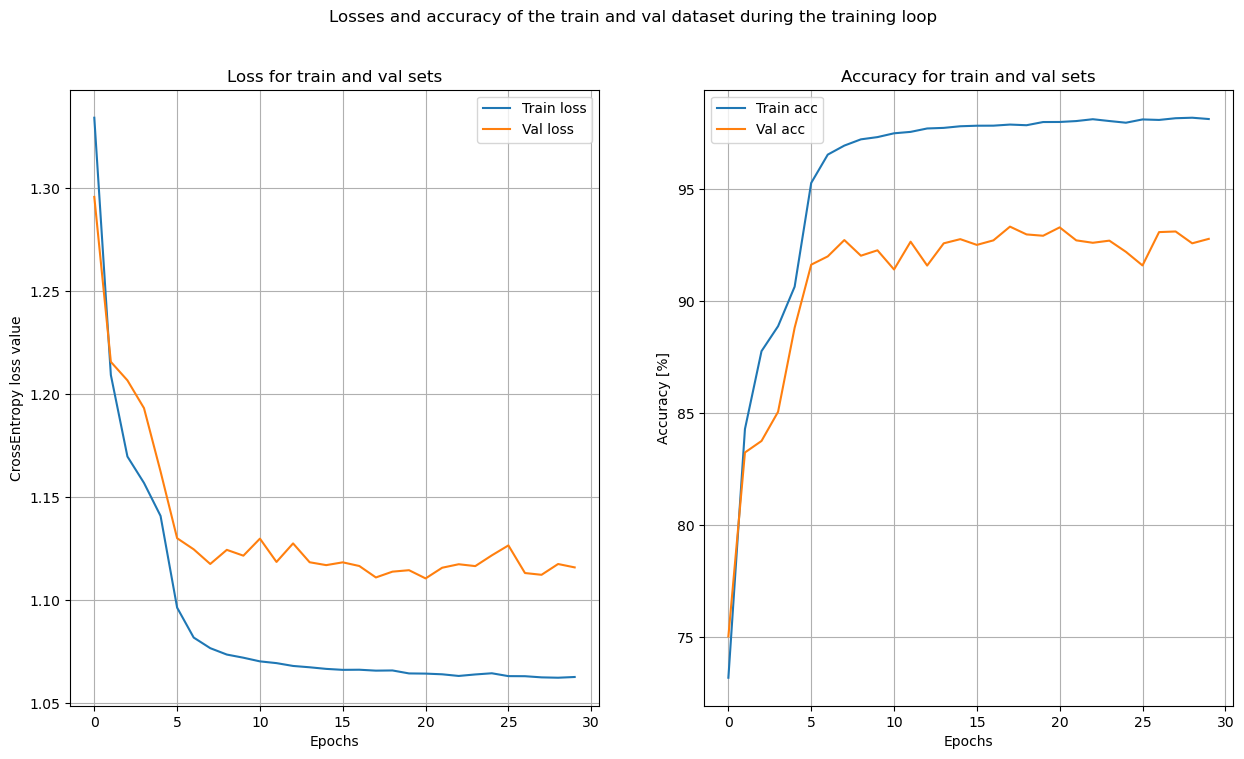

In [ ]:
fig, axs = plt.subplots(ncols = 2 , nrows = 1, figsize = (15,8))
fig.suptitle('Losses and accuracy of the train and val dataset during the training loop')
axs[0].set_title('Loss for train and val sets')
axs[0].plot(CNN_tot_train_loss,label = 'Train loss')
axs[0].plot(CNN_tot_val_loss, label = 'Val loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('CrossEntropy loss value')
axs[0].grid()
axs[0].legend()

axs[1].set_title('Accuracy for train and val sets')
axs[1].plot(CNN_tot_train_acc,label = 'Train acc')
axs[1].plot(CNN_tot_val_acc, label = 'Val acc')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy [%]')
axs[1].grid()
axs[1].legend()
plt.show()

In [ ]:
CNN_predictions ,CNN_labels_list, CNN_tot_test_acc = test_model(Our_First_CNN , device_to_use , test_loader,use_argmax= True )
print('Test accuracy {}'.format(CNN_tot_test_acc))

Test accuracy 94.96307517515622


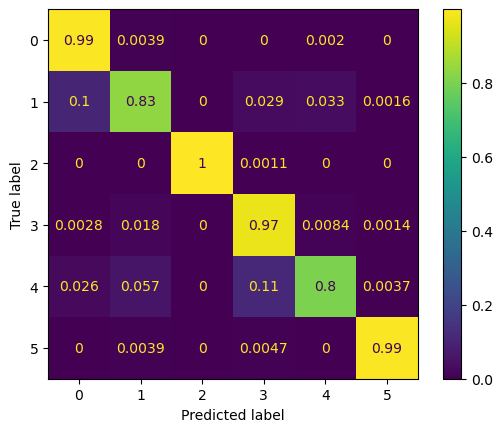

In [ ]:
test_QM = confusion_matrix(CNN_predictions,CNN_labels_list,normalize = 'true')
cm_display = ConfusionMatrixDisplay(confusion_matrix = test_QM, display_labels = MS_HAR_labels.numpy())
cm_display.plot()

# Notice the following:

**1. First and most important - we got way better resultsת a 5% increase in accuracy in total, and for all classes with the CNN**

**2.The FC DNN has 32214 parameters while the CNN has 55814 almost twice as much, in other words, the CNN achieved the same results and BETTER as the DNN with 40% LESS PARAMETERS**

**3. Finding a good CNN is not easy, we have to tune the kernel size, number of layer, stride, channels in and out, etc. but the results can be quite good**